# Installation & Setup

In [ ]:
#this cell only needs to be run once for every new run time
# Deleted a few things from code from Cynthia
!pip install transformers[torch,sentencepiece] torch datasets -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 790.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
# Deleted a few things from prior code

#important relevant modeling libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Code copied from Cynthia
from datasets import Dataset

# Code copied from https://huggingface.co/learn/nlp-course/chapter0/1?fw=pt.
import transformers

from transformers import AutoModel, AutoTokenizer, AddedToken
# Code copied from: https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt and https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
from tqdm.auto import tqdm

In [ ]:
#copy this block over for all successive model iterations
import pandas as pd
import os
import json
import numpy as np
import ast

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Code may copy from lesson_4_BERT.ipynb

model_name = "bert-base-uncased"
bert_model = AutoModel.from_pretrained(model_name)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Data processing for model specifically

In [ ]:
# Changing max length to 512 as 512 is the maximium for BERT (copied from: https://huggingface.co/learn/nlp-course/)
max_length = 512

In [ ]:
# Function to pad or truncate the key_timing data
def pad_or_truncate(array):
    if len(array) < max_length:
        # If the array is shorter than the desired length, pad it with zeros.
        # You can use np.pad to add zeros at the end of the array.
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=(0.0))
    else:
        # If the array is longer than the desired length, truncate it.
        # You can use array slicing to keep only the first 'desired_length' elements.
        return array[:max_length]

# Function to convert a string to a Python list
def string_to_list(input_string):
    return ast.literal_eval(input_string)

# Convert object dtype to lists of floats using custom parsing
def custom_parse_string_to_list(input_string):
    # Remove brackets and split by ', ' to get individual values
    values = input_string.strip('[]').split(', ')

    # Convert values to floats (handling 'nan' string separately)
    result = [float(val) if val != 'nan' else 0 for val in values]

    return result

In [ ]:
######################## READ IN DATA ###################################################################################################
data_path = '/content/drive/My Drive/266 Assignments/266 Final Project'
files = os.listdir(data_path)
files = [x for x in files if '.csv' in x]

filt_df = pd.read_csv(os.path.join(data_path, files[files.index('cleaned_data_with_ft.csv')]))

#do some data cleanup to ensure timing sequence is in right data format
# filt_df['flight_time'] = filt_df['flight_time'].apply(string_to_list)
# Apply the custom parsing function to convert string to list of floats
filt_df['flight_time'] = filt_df['flight_time'].apply(custom_parse_string_to_list)
filt_df['flight_time'] = filt_df['flight_time'].apply(pad_or_truncate)

In [ ]:
######################## IMPORT SPECIAL TOKENS ############################################################################################
json_file = os.path.join(data_path, "token_map.json")
with open(json_file, 'r') as json_file:
    charbert_token_map = json.load(json_file)

added_tokens = [AddedToken(token) for token in charbert_token_map.values()]
# added_tokens

In [ ]:
# Add the special tokens from charbert_token_map to the tokenizer's vocabulary
# Looks like [unused1] to [unused26] are present for "bert-base-uncased" too: https://huggingface.co/bert-base-uncased/blob/main/vocab.txt
bert_tokenizer.add_tokens(added_tokens)

26

In [ ]:
# must also add special tokens to the model
bert_model.resize_token_embeddings(len(bert_tokenizer))

Embedding(30522, 768, padding_idx=0)

In [ ]:
#resample the data to balance it exactly 50-50 HC-PD

#separate the classes
class_1 = filt_df[filt_df['diagnosis'] == 1]
class_0 = filt_df[filt_df['diagnosis'] == 0]

#downsample the majority class
class_0_down = resample(class_0, replace=False, n_samples = len(class_1), random_state=42)

# Combine minority class with downsampled majority class
balanced_data = pd.concat([class_1, class_0_down])
len(balanced_data)

2940

In [ ]:
#split the data
# Split the data into training, validation, and test sets
X = balanced_data[['key_sequence', 'flight_time']]
y = balanced_data['diagnosis']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Put data into a pandas dataframe to then load into a hugging face dataset object
# Code and idea copied from https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
train_df = X_train
train_df['labels']=y_train
train_df.columns = ['key_seq', 'flight_time','labels']

# Code copied from above
# Made a df of our validation data
val_df = X_val
val_df['labels']=y_val
val_df.columns = ['key_seq', 'flight_time','labels']

test_df = X_test
test_df['labels']=y_test
test_df.columns = ['key_seq', 'flight_time','labels']

In [ ]:
# Code copied from https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
# Make a hugging face dataset object from the pandas df we just made
train_dataset = Dataset.from_pandas(train_df)

# Code copied from above
# Make a validation Dataset
val_dataset = Dataset.from_pandas(val_df)

# Code copied from above
# Make a test Dataset
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt and prior code above (likely from BERT lesson notebooks/assignment)
# Code also copied from https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt
# Create a tokenize function we'll use to tokenize the key sequences in the dataset
def tokenize_func(a):
  return bert_tokenizer(
    a['key_seq'],
    # Changing padding to max_length, copied from https://huggingface.co/learn/nlp-course/chapter2/6?fw=pt
    # Getting rid of padding here (copying from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt).
    # It's more efficient to do padding at the batch level later on (use "dynamic padding") according to the above source
    padding='max_length',
    # Trunction true should truncate to max length: Copied from https://huggingface.co/docs/transformers/main_classes/tokenizer
    truncation=True,
    # Testing a shorter max length based on https://huggingface.co/learn/nlp-course/chapter2/5?fw=pt
    # Getting rid of max length from here to, copying from: https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
    # Reinstating max length since got an error
    max_length=max_length,
    # Getting rid of return tensors so that this code runs! Gave an erron when it was here
    # return_tensors='pt'
    )

In [ ]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
# Tokenize the key sequences which will add the results to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_func, batched=True)

# Code copied from above
# Tokenize validation dataset
tokenized_val_dataset = val_dataset.map(tokenize_func, batched=True)

# Code copied from above
# Tokenize test dataset
tokenized_test_dataset = test_dataset.map(tokenize_func, batched=True)


Map:   0%|          | 0/2058 [00:00<?, ? examples/s]

Map:   0%|          | 0/441 [00:00<?, ? examples/s]

Map:   0%|          | 0/441 [00:00<?, ? examples/s]

In [ ]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Get rid of all columns in our dataset that our model won't accept
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['key_seq', '__index_level_0__',])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(['key_seq', '__index_level_0__',])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['key_seq', '__index_level_0__',])

In [ ]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Set output to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

In [ ]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Check column names align with what model expects
tokenized_train_dataset.column_names

['flight_time', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
  # Copied from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt:
  # "... apply the correct amount of padding to the items of the dataset we want to batch together.
  # ... such a function via DataCollatorWithPadding. It takes a tokenizer when you instantiate it
   #(to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs)
# Setting max length, and padding - copied from https://huggingface.co/docs/transformers/main_classes/data_collator
# Errored out, so got rid of these
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [ ]:
#make data loaders
batch_size = 8


train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(tokenized_val_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

In [ ]:
# Check of Dataloader copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'flight_time': torch.Size([8, 512]),
 'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 512]),
 'token_type_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512])}

# BERT Model + LSTM


*   Feed BERT embeddings alone into an LSTM layer
*   Then concatenate to key timings and put into another LSTM layer



In [ ]:
# Additional features input size
additional_features_size = max_length

In [ ]:
# # Code copied from Cynthia.
# # Changes I've made may copy from throughout this course: https://huggingface.co/learn/nlp-course**
# # May also copy from lesson_4_BERT.ipynb

# class CustomModel(nn.Module):
#     def __init__(self, bert_model, additional_features_size, num_labels=2):
#         super(CustomModel, self).__init__()
#         self.bert_model = bert_model
#         self.additional_features_size = additional_features_size

#         # Add LSTM layers for additional features
#         self.lstm1 = nn.LSTM(input_size=additional_features_size, hidden_size=64, batch_first=True)
#         self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
#         self.lstm3 = nn.LSTM(input_size=32, hidden_size=16, batch_first=True)

#         # Output layer for binary classification
#         self.classifier = nn.Linear(768 + 16, num_labels)  # 768 is the size of the BERT embeddings

#     def forward(self, input_ids, attention_mask, token_type_ids, time_seq):
#         # BERT forward pass
#         bert_outputs = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
#         bert_cls = bert_outputs[0][:,0,:] # Copying from above (see corresponding sources), getting the CLS token

#         # LSTM forward pass for additional features
#         lstm_outputs1, _ = self.lstm1(time_seq)
#         lstm_outputs2, _ = self.lstm2(lstm_outputs1)
#         lstm_outputs3, _ = self.lstm3(lstm_outputs2)

#         # Concatenate BERT CLS and LSTM outputs
#         combined_features = torch.cat((bert_cls, lstm_outputs3), dim=1)

#         # Classification layer
#         logits = self.classifier(combined_features)

#         return logits

In [ ]:
# # Model with no BERT

# class CustomModel(nn.Module):
#     def __init__(self, bert_model, additional_features_size, num_labels=2):
#         super(CustomModel, self).__init__()
#         self.bert_model = bert_model
#         self.additional_features_size = additional_features_size

#         # Add LSTM layers for additional features
#         self.lstm1 = nn.LSTM(input_size=(additional_features_size), hidden_size=64, batch_first=True)
#         self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)

#         # Output layer for binary classification
#         self.classifier = nn.Linear(32, num_labels)

#     def forward(self, input_ids, attention_mask, token_type_ids, time_seq):
#         # BERT forward pass
#         bert_outputs = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
#         bert_cls = bert_outputs[0][:,0,:] # Copying from above (see corresponding sources), getting the CLS token

#         # Concatenate BERT CLS and LSTM outputs
#         combined_features = time_seq

#         # LSTM forward pass for additional features
#         lstm_outputs1, _ = self.lstm1(combined_features)
#         lstm_outputs2, _ = self.lstm2(lstm_outputs1)

#         # Classification layer
#         logits = self.classifier(lstm_outputs2)

#         return logits

In [ ]:
# # Code copied from above with architecture changed

# class CustomModel(nn.Module):
#     def __init__(self, bert_model, additional_features_size, num_labels=2):
#         super(CustomModel, self).__init__()
#         self.bert_model = bert_model
#         self.additional_features_size = additional_features_size

#         # Add LSTM layers for additional features
#         self.lstm1 = nn.LSTM(input_size=768, hidden_size=512, batch_first=True) #BERT alone
#         self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)
#         self.lstm3 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
#         self.lstm4 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
#         self.lstm5 = nn.LSTM(input_size=(64+additional_features_size), hidden_size=32, batch_first=True)

#         # Output layer for binary classification
#         self.classifier = nn.Linear(32, num_labels)

#     def forward(self, input_ids, attention_mask, token_type_ids, time_seq):
#         # BERT forward pass
#         bert_outputs = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
#         bert_cls = bert_outputs[0][:,0,:] # Copying from above (see corresponding sources), getting the CLS token



#         # LSTM forward pass for additional features
#         lstm_outputs1, _ = self.lstm1(bert_cls)
#         lstm_outputs2, _ = self.lstm2(lstm_outputs1)
#         lstm_outputs3, _ = self.lstm3(lstm_outputs2)
#         lstm_outputs4, _ = self.lstm4(lstm_outputs3)

#         # Concatenate BERT CLS and LSTM outputs
#         combined_features = torch.cat((lstm_outputs4, time_seq), dim=1)

#         lstm_outputs5, _ = self.lstm5(combined_features)

#         # Classification layer
#         logits = self.classifier(lstm_outputs5)

#         return logits

In [ ]:
# Code copied from above with architecture changed

class CustomModel(nn.Module):
    def __init__(self, bert_model, additional_features_size, num_labels=2):
        super(CustomModel, self).__init__()
        self.bert_model = bert_model
        self.additional_features_size = additional_features_size

        # Add LSTM layers for additional features
        self.lstm1 = nn.LSTM(input_size=(768+additional_features_size), hidden_size=512, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)
        # self.lstm3 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        # self.lstm4 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        # self.lstm5 = nn.LSTM(input_size=(64+additional_features_size), hidden_size=32, batch_first=True)

        # Output layer for binary classification
        self.classifier = nn.Linear(512, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids, flight_time):
        # BERT forward pass
        bert_outputs = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        bert_cls = bert_outputs[0][:,0,:] # Copying from above (see corresponding sources), getting the CLS token

        # # LSTM forward pass for additional features
        # lstm_outputs1, _ = self.lstm1(bert_cls)
        # lstm_outputs2, _ = self.lstm2(lstm_outputs1)
        # lstm_outputs3, _ = self.lstm3(lstm_outputs2)
        # lstm_outputs4, _ = self.lstm4(lstm_outputs3)

        # Concatenate BERT CLS and LSTM outputs
        combined_features = torch.cat((bert_cls, flight_time), dim=1)

        lstm_outputs1, _ = self.lstm1(combined_features)

        # Classification layer
        logits = self.classifier(lstm_outputs1)

        return logits

In [ ]:
# Instantiate the custom model
model = CustomModel(bert_model, additional_features_size)

In [ ]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Set up to use the GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

## Training the model



In [ ]:
# Define helper functions to calculate accuracy
# Code and comments copied from https://medium.com/p/a70372764432

def get_accuracy(model, dataloader):
  '''puts model in evaluation mode then gets accuracy'''
  model = model.eval()
  correct = 0
  total_examples = 0
  for i, batch in enumerate(dataloader):
    with torch.no_grad():
      logits = model(input_ids = batch['input_ids'].to(device), # Copying from https://discuss.pytorch.org/t/expected-all-tensors-to-be-on-the-same-device-but-found-at-least-two-devices-cuda-0-and-cpu/98537/2, putting input data to the same device as the model
        attention_mask = batch['attention_mask'].to(device),
        token_type_ids = batch['token_type_ids'].to(device),
        flight_time = batch['flight_time'].to(device)
        )
    predictions =  torch.argmax(logits, dim=1) # Copied from https://pytorch.org/docs/stable/generated/torch.argmax.html
    labels = batch['labels'].to(device)
    labels = labels.view(predictions.shape)
    comparison = labels == predictions
    correct += torch.sum(comparison)
    total_examples += len(comparison)

  return correct / total_examples

In [ ]:
num_epochs = 5

In [ ]:
# Code copied from Cynthia
learning_rate=2e-5
#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Code copied from Cynthia
# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Set up to get a progress bar
num_train_steps = num_epochs*len(train_dataloader)

In [ ]:
# Code copied from Cynthia
# Changes I've made may copy from throughout this course: https://huggingface.co/learn/nlp-course**
# May also copy from lesson_4_BERT.ipynb
# Training loop

progress_bar = tqdm(range(num_train_steps))

for epoch in range(num_epochs):
    model = model.train()
    train_loss = 0.0
    val_loss = 0.0
    # Training loop
    for batch in train_dataloader:

        input_ids = batch['input_ids'].to(device) # Copying from https://discuss.pytorch.org/t/expected-all-tensors-to-be-on-the-same-device-but-found-at-least-two-devices-cuda-0-and-cpu/98537/2, putting input data to the same device as the model
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        flight_time = batch['flight_time'].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, flight_time=flight_time)

        loss = criterion(outputs, batch["labels"].to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        progress_bar.update(1)

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    train_accuracy = get_accuracy(model,train_dataloader)
    val_accuracy = get_accuracy(model,val_dataloader)

    # Code copies from https://medium.com/p/a70372764432 and above (see corresponding sources)
    # Evaluation loop to get validation loss
    model = model.eval()
    for batch in val_dataloader:

        input_ids = batch['input_ids'].to(device) # Copying from https://discuss.pytorch.org/t/expected-all-tensors-to-be-on-the-same-device-but-found-at-least-two-devices-cuda-0-and-cpu/98537/2, putting input data to the same device as the model
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        flight_time = batch['flight_time'].to(device)

        with torch.no_grad():
          outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, flight_time=flight_time)
          loss = criterion(outputs, batch["labels"].to(device))
          val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}  Train Accuracy: {train_accuracy:.4f}  Val Loss: {avg_val_loss:.4f}  Val Accuracy: {val_accuracy:.4f}")

  0%|          | 0/1290 [00:00<?, ?it/s]

Epoch 1/5: Train Loss: 0.6463  Train Accuracy: 0.6618  Val Loss: 0.6204  Val Accuracy: 0.6463
Epoch 2/5: Train Loss: 0.6026  Train Accuracy: 0.6793  Val Loss: 0.6104  Val Accuracy: 0.6395
Epoch 3/5: Train Loss: 0.5816  Train Accuracy: 0.6939  Val Loss: 0.5930  Val Accuracy: 0.6553
Epoch 4/5: Train Loss: 0.5643  Train Accuracy: 0.7148  Val Loss: 0.5771  Val Accuracy: 0.6712
Epoch 5/5: Train Loss: 0.5459  Train Accuracy: 0.7308  Val Loss: 0.5585  Val Accuracy: 0.6871


In [ ]:
#modified get predictions function
def get_predictions(model, dataloader):
    model = model.eval()
    predictions_list = []
    true_labels_list = []

    # Initialize a DataFrame to record predictions, true values and inputs
    pred_df = pd.DataFrame(columns=['prediction', 'true_label', 'flight_time', 'input_ids', 'attention_mask', 'token_type_ids'])

    for batch in dataloader:
        with torch.inference_mode():
            logits = model(input_ids=batch['input_ids'].to(device),
                           attention_mask=batch['attention_mask'].to(device),
                           token_type_ids=batch['token_type_ids'].to(device),
                           flight_time = batch['flight_time'].to(device))

        predictions = torch.argmax(logits, dim=1)
        predictions = list(predictions.cpu().numpy())
        true_labels = list(batch['labels'].cpu().numpy())  # Replace 'labels' with your true labels key

        predictions_list.extend(predictions)
        true_labels_list.extend(true_labels)

        # Iterate through each batch to record prediction, label and inputs
        for i in range(len(batch['flight_time'])):
          # Code copied from https://www.geeksforgeeks.org/how-to-add-one-row-in-an-existing-pandas-dataframe/
          pred_df = pred_df.append({'prediction':predictions[i],
                          'true_label':true_labels[i],
                          'flight_time':list(batch['flight_time'][i].numpy()),
                          'input_ids':list(batch['input_ids'][i].numpy()),
                          'attention_mask':list(batch['attention_mask'][i].numpy()),
                          'token_type_ids':list(batch['token_type_ids'][i].numpy())},
                          ignore_index=True)
    return predictions_list, true_labels_list, pred_df

In [ ]:
# Code copied from above (see corresponding sources)
# Get probs for AUC calculation
def get_probs(model, dataloader):
    model = model.eval()
    probs_list = []
    true_labels_list = []

    for batch in dataloader:
        with torch.inference_mode():
            logits = model(input_ids=batch['input_ids'].to(device),
                           attention_mask=batch['attention_mask'].to(device),
                           token_type_ids=batch['token_type_ids'].to(device),
                           flight_time = batch['flight_time'].to(device))

        softmax = nn.Softmax(dim=1) # Copied from https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
        probs = softmax(logits)

        probs = list(probs.cpu().numpy())

        true_labels = list(batch['labels'].cpu().numpy())  # Replace 'labels' with your true labels key

        for prob in probs:
          probs_list.append(prob[1])
        true_labels_list.extend(true_labels)

    return probs_list, true_labels_list


In [ ]:
bert_lstm_val_predictions, true_val_labels, val_df = get_predictions(model, val_dataloader)

<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated an

In [ ]:
# Now let's evaluate the model (code copied from prior notebook)

accuracy_val = accuracy_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))
precision_val = precision_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))
recall_val = recall_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))
f1_val = f1_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))

print("Accuracy: ", accuracy_val)
print("Precision: ", precision_val)
print("Recall: ", recall_val)
print("F1-Score: ", f1_val)

Accuracy:  0.6780045351473923
Precision:  0.8876404494382022
Recall:  0.3744075829383886
F1-Score:  0.5266666666666666


In [ ]:
bert_lstm_test_predictions, true_test_labels, test_df = get_predictions(model, test_dataloader)

<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append({'prediction':predictions[i],
<ipython-input-183-32907265c1f5>:27: FutureWarning: The frame.append method is deprecated an

In [ ]:
bert_lstm_test_probs, true_test_labels_for_probs = get_probs(model, test_dataloader)

In [ ]:
# Now let's evaluate the model (code copied from prior notebook)

accuracy_test = accuracy_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
precision_test = precision_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
recall_test = recall_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
f1_test = f1_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
auc_test = roc_auc_score(np.array(true_test_labels_for_probs), np.array(bert_lstm_test_probs))

print("Accuracy: ", accuracy_test)
print("Precision: ", precision_test)
print("Recall: ", recall_test)
print("F1-Score: ", f1_test)
print("AUC: ", auc_test)

Accuracy:  0.7074829931972789
Precision:  0.9206349206349206
Recall:  0.49361702127659574
F1-Score:  0.6426592797783933
AUC:  0.8482338359843007


In [ ]:
def decode_inputs(row):
  return bert_tokenizer.decode(row['input_ids'])

In [ ]:
# Decode each row
# Code copied from https://www.geeksforgeeks.org/apply-function-to-every-row-in-a-pandas-dataframe/
# and https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.convert_tokens_to_string
test_df['tokens'] = test_df.apply(decode_inputs, axis = 1)
test_df

,prediction,true_label,flight_time,input_ids,attention_mask,token_type_ids,tokens
0,1,1,"[212.0, 487.0, 132.0, 270.0, 236.0, 391.0, 180...","[101, 2, 1043, 1041, 1050, 1041, 1054, 1037, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] g e n e r a l l y [unused3] c ...
1,0,0,"[119.89, 136.0, 144.36, 199.63, 768.065, 207.9...","[101, 2, 1056, 1044, 1041, 1061, 4, 1042, 1051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e y [unused3] f o u g h t ...
2,1,1,"[217.0, 666.0, 174.0, 265.0, 304.0, 144.0, 198...","[101, 2, 1038, 1051, 1051, 1047, 1055, 4, 1045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] b o o k s [unused3] i n c l u ...
3,0,0,"[486.92, 30.86, 30.355, 14.125, 429.58, 174.75...","[101, 2, 2, 2, 2, 1038, 1051, 1051, 1047, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] [unused1] [unused1] [unused1] ...
4,0,0,"[199.415, 248.325, 183.895, 464.12, 631.645, 3...","[101, 2, 1056, 1044, 1041, 4, 1059, 1011, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] w - s h a p e ...
...,...,...,...,...,...,...,...
436,0,0,"[167.96, 231.805, 108.09, 207.98, 1084.12, 747...","[101, 2, 1056, 1044, 1041, 4, 1059, 1011, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] w - s h a p e ...
437,0,1,"[240.095, 544.05, 464.12, 311.87, 280.225, 368...","[101, 2, 1043, 1041, 1050, 1041, 1054, 1037, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] g e n e r a l l y [unused3] c ...
438,0,1,"[349.24, 417.375, 302.04, 270.245, 234.325, 23...","[101, 2, 1037, 1048, 1056, 1044, 1051, 1057, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] a l t h o u g h [unused3] e a ...
439,1,1,"[239.0, 427.0, 90.0, 161.0, 190.0, 208.0, 70.0...","[101, 2, 1056, 1044, 1041, 4, 1050, 1051, 1058...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] n o v e l [unu...


In [ ]:
# Look at true positives
# Code copied from https://www.geeksforgeeks.org/filter-pandas-dataframe-with-multiple-conditions/
test_df.loc[(test_df['prediction']==1)&(test_df['true_label']==1)]

,prediction,true_label,flight_time,input_ids,attention_mask,token_type_ids,tokens
0,1,1,"[212.0, 487.0, 132.0, 270.0, 236.0, 391.0, 180...","[101, 2, 1043, 1041, 1050, 1041, 1054, 1037, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] g e n e r a l l y [unused3] c ...
2,1,1,"[217.0, 666.0, 174.0, 265.0, 304.0, 144.0, 198...","[101, 2, 1038, 1051, 1051, 1047, 1055, 4, 1045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] b o o k s [unused3] i n c l u ...
7,1,1,"[192.0, 232.0, 128.0, 216.0, 96.0, 96.0, 208.0...","[101, 2, 1056, 1044, 1041, 4, 2, 1042, 1054, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] [unused1] f r ...
8,1,1,"[296.0, 663.0, 279.0, 269.0, 429.0, 728.0, 966...","[101, 2, 1055, 1052, 1048, 1045, 1056, 1011, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] s p l i t - f i n g e r [unuse...
13,1,1,"[128.685, 773.28, 2813.75, 168.015, 188.895, 6...","[101, 1055, 2, 1052, 1048, 1045, 1056, 1011, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] s [unused1] p l i t - f i n g e r [unuse...
...,...,...,...,...,...,...,...
415,1,1,"[156.0, 250.0, 188.0, 78.0, 141.0, 78.0, 234.0...","[101, 2, 1037, 1048, 1056, 1044, 1051, 1057, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] a l t h o u g h [unused3] e a ...
416,1,1,"[167.935, 368.05, 263.965, 160.055, 55.965, 23...","[101, 2, 1051, 1058, 1041, 1054, 4, 1056, 1044...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] o v e r [unused3] t h r e e [u...
421,1,1,"[57.0, 319.0, 216.0, 232.0, 1769.0, 63.0, 931....","[101, 2, 1056, 1044, 1041, 4, 2, 1047, 1051, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] [unused1] k o ...
422,1,1,"[160.375, 311.455, 171.575, 311.505, 194.065, ...","[101, 2, 1038, 1051, 1051, 1047, 1055, 4, 1045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] b o o k s [unused3] i n c l u ...


In [ ]:
test_df['tokens'][13]

'[CLS] s [unused1] p l i t - f i n g e r [unused3] a i m i n g [unused3] r e q u i r e s [unused3] t h e [unused3] a r c h e r [unused3] t o [unused3] p l a c e [unused3] t h e [unused3] i n d e x [unused3] f i n g e r [unused3] a b o e [unused3] t h e [unused3] n o c k e d [unused3] a r r o w, [unused3] w h i e l [unused3] t h e [unused3] i d d l e [unused3] a n d [unused3] r i n g [unused3] f i n g e r s [unused3] a r e [unused3] b o t h p l a c e d [unused3] b e l o w [unused4] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
# Look at true negatives
# Code copied from https://www.geeksforgeeks.org/filter-pandas-dataframe-with-multiple-conditions/
test_df.loc[(test_df['prediction']==0)&(test_df['true_label']==0)]

,prediction,true_label,flight_time,input_ids,attention_mask,token_type_ids,tokens
1,0,0,"[119.89, 136.0, 144.36, 199.63, 768.065, 207.9...","[101, 2, 1056, 1044, 1041, 1061, 4, 1042, 1051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e y [unused3] f o u g h t ...
3,0,0,"[486.92, 30.86, 30.355, 14.125, 429.58, 174.75...","[101, 2, 2, 2, 2, 1038, 1051, 1051, 1047, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] [unused1] [unused1] [unused1] ...
4,0,0,"[199.415, 248.325, 183.895, 464.12, 631.645, 3...","[101, 2, 1056, 1044, 1041, 4, 1059, 1011, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] w - s h a p e ...
9,0,0,"[488.115, 31.24, 46.875, 19.205, 32.57, 44.075...","[101, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1048, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] [unused1] [unused1] [unused1] ...
11,0,0,"[144.0, 278.0, 194.0, 523.0, 437.0, 262.0, 274...","[101, 2, 1056, 1044, 1041, 4, 1059, 1011, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] w - s h a p e ...
...,...,...,...,...,...,...,...
433,0,0,"[188.0, 141.0, 124.0, 157.0, 219.0, 125.0, 125...","[101, 2, 1056, 1044, 1041, 1061, 4, 1042, 1051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e y [unused3] f o u g h t ...
434,0,0,"[312.925, 621.695, 297.3, 293.93, 120.935, 309...","[101, 2, 1044, 1041, 4, 1045, 1055, 4, 1038, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] h e [unused3] i s [unused3] b ...
435,0,0,"[283.0, 202.0, 32.0, 140.0, 174.0, 514.0, 31.0...","[101, 2, 1056, 1044, 1041, 4, 2, 2, 2, 2, 2, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] [unused1] [unu...
436,0,0,"[167.96, 231.805, 108.09, 207.98, 1084.12, 747...","[101, 2, 1056, 1044, 1041, 4, 1059, 1011, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] w - s h a p e ...


In [ ]:
test_df['tokens'][433]

'[CLS] [unused1] t h e y [unused3] f o u g h t [unused3] a [unused3] t h i r t y [unused3] y e a r s [unused3] w a r [unused3] o n [unused3] t h e [unused3] s i d e [unused3] o f [unused3] t h e [unused3] [unused1] l a m t u n a [unused3] [unused1] a r a b i z e d [unused3] [unused1] b e r b e r s [unused3] w h o [unused3] c l a i m e d [unused3] [unused1] h i m y a r i t e [unused3] a n c e s t r y [unused3] f o [unused2] r o m [unused3] t h e [unused3] e a r l y [unused3] [unused1] i s l a m i c [unused3] i n v a s i o n s [unused4] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
# Look at false positives
# Code copied from https://www.geeksforgeeks.org/filter-pandas-dataframe-with-multiple-conditions/
test_df.loc[(test_df['prediction']==1)&(test_df['true_label']==0)]

,prediction,true_label,flight_time,input_ids,attention_mask,token_type_ids,tokens
60,1,0,"[1.035, 0.3, 0.37, 0.375, 0.36, 0.305, 0.405, ...","[101, 1044, 1051, 1059, 1041, 1058, 1041, 1054...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[CLS] h o w e v e r, [unused3] r e l i g i o n..."
159,1,0,"[215.0, 882.0, 262.0, 232.0, 278.0, 2228.0, 66...","[101, 2, 1055, 1052, 1048, 1045, 1056, 1011, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] s p l i t - f i n g e r [unuse...
163,1,0,"[0.49, 1.02, 0.35, 0.235, 0.24, 0.21, 0.245, 0...","[101, 2, 1038, 1051, 1051, 1047, 1055, 4, 1045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] b o o k s [unused3] i n c l u ...
200,1,0,"[463.095, 412.45, 421.97, 253.48, 435.56, 299....","[101, 2, 1044, 1051, 1059, 1041, 1058, 1041, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[CLS] [unused1] h o w e v e r, [unused3] s o m..."
229,1,0,"[0.465, 0.32, 0.285, 0.23, 0.155, 0.225, 0.36,...","[101, 2, 1048, 1045, 1050, 1039, 1051, 1048, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] l i n c o l n's [unused3] c o ...
234,1,0,"[87.79992, 227.60023, 88.29992, 188.79984, 247...","[101, 2, 1044, 1051, 1059, 1041, 1058, 1041, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[CLS] [unused1] h o w e v e r, [unused6] [unus..."
265,1,0,"[316.99, 248.935, 102.015, 224.12, 94.91, 85.1...","[101, 2, 1044, 1041, 4, 1045, 1055, 4, 1038, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] h e [unused3] i s [unused3] b ...
305,1,0,"[42.0, 611.0, 216.0, 234.0, 304.0, 327.0, 112....","[101, 2, 1044, 1051, 1059, 1041, 1058, 1041, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[CLS] [unused1] h o w e v e r, [unused3] r e l..."
409,1,0,"[178.23, 194.545, 141.945, 675.04, 100.595, 13...","[101, 2, 1048, 1045, 1050, 1039, 1051, 1048, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] l i n c o l n's [unused3] c o ...
429,1,0,"[113.765, 216.34, 139.475, 146.02, 141.635, 14...","[101, 2, 1037, 1055, 4, 1051, 1042, 4, 1016, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] a s [unused3] o f [unused3] 2 ...


In [ ]:
test_df['tokens'][234]

'[CLS] [unused1] h o w e v e r, [unused6] [unused3] t h e r e [unused3] i s [unused3] n o [unused3] e v i d e n c e [unused3] t h a t [unused3] t h o s e [unused3] t a t t o o s [unused3] w e r e [unused3] u s e d [unused3] a s [unused3] a c u p u n c t u r e [unused3] p o i n t s [unused3] o r [unused3] i f [unused3] t h e y [unused3] w e r e [unused3] j u s t [unused3] d e c o r a t i v e [unused3] i n [unused3] n a t u r e [unused4] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
# Look at false negatives
# Code copied from https://www.geeksforgeeks.org/filter-pandas-dataframe-with-multiple-conditions/
test_df.loc[(test_df['prediction']==0)&(test_df['true_label']==1)]

,prediction,true_label,flight_time,input_ids,attention_mask,token_type_ids,tokens
5,0,1,"[153.0, 467.0, 70.0, 227.0, 95.0, 236.0, 139.0...","[101, 2, 1056, 1044, 1041, 1061, 4, 1042, 1051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e y [unused3] f o u g h [u...
6,0,1,"[216.0, 280.0, 152.0, 120.0, 192.0, 448.0, 136...","[101, 2, 1056, 1044, 1041, 1061, 4, 1042, 1051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e y [unused3] f o u g h t ...
10,0,1,"[94.0, 295.0, 256.0, 194.0, 122.0, 244.0, 232....","[101, 2, 1048, 1045, 1050, 1040, 1051, 1048, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] l i n d o l n'[unused2] [unuse...
15,0,1,"[177.175, 448.135, 104.295, 587.25, 455.105, 2...","[101, 2, 1056, 1044, 1041, 4, 2, 1042, 1054, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] [unused1] f r ...
17,0,1,"[232.63, 927.645, 198.27, 299.11, 233.63, 235....","[101, 2, 1037, 1056, 1044, 1051, 1057, 1043, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] a t h o u g h [unused3] e a r ...
...,...,...,...,...,...,...,...
420,0,1,"[125.0, 187.0, 95.0, 139.0, 267.0, 500.0, 421....","[101, 2, 1056, 1044, 1041, 4, 1059, 1011, 1055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] w - s h a p e ...
423,0,1,"[118.69981, 255.99998, 120.20014, 159.79982, 1...","[101, 2, 1056, 1044, 1041, 4, 2, 1042, 1054, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e [unused3] [unused1] f r ...
428,0,1,"[131.935, 463.88, 251.965, 244.76, 250.04, 623...","[101, 2, 1056, 1044, 1041, 1061, 4, 1042, 1051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] t h e y [unused3] f o u g h t ...
437,0,1,"[240.095, 544.05, 464.12, 311.87, 280.225, 368...","[101, 2, 1043, 1041, 1050, 1041, 1054, 1037, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[CLS] [unused1] g e n e r a l l y [unused3] c ...


In [ ]:
test_df['tokens'][5]

'[CLS] [unused1] t h e y [unused3] f o u g h [unused3] a [unused3] t h i r t y [unused3] y e a r s [unused3] w a r [unused3] o n [unused3] t h e [unused3] s i d e [unused3] o f [unused3] t h e [unused3] [unused1] l a m t u n a [unused3] [unused1] a r a b i z e d [unused3] [unused1] b e r b e r s [unused3] w h o [unused3] c l a i m e d [unused3] [unused1] h i m y a r i t e [unused3] a n c e s r [unused2] t r y [unused3] f o r [unused3] t h e [unused3] e a r l y [unused3] [unused1] i s l a m i c [unused3] i n v a s i o m s [unused2] [unused2] n s [unused4] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

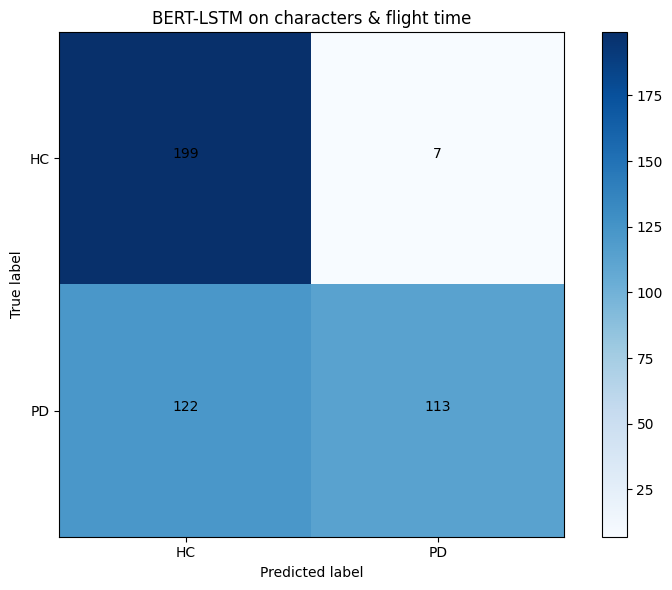

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

name = "BERT-LSTM on characters & flight time"
# Compute confusion matrix
cm = confusion_matrix(true_test_labels, bert_lstm_test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(name)
plt.colorbar()

classes = ['HC', 'PD']  # Change these labels according to your classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
#save the confusion matrix

file_name = f"confusion_matrix_{name}.png"
plt.savefig(os.path.join(data_path, file_name))

<Figure size 640x480 with 0 Axes>

In [ ]:
import csv
from datetime import datetime

def write_metrics_to_csv(filename, metrics):
    try:
        with open(filename, 'a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=metrics.keys())
            if file.tell() == 0:
              writer.writeheader()  # Write header if the file is empty

            writer.writerow(metrics)
    except IOError:
        print("Error writing to file")

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

metrics = {
    "model name": name,
    "timestamp": timestamp,
    "accuracy": accuracy_test,
    "precision": precision_test,
    "recall": recall_test,
    "f1": f1_test,
    "auc": auc_test
}

# Write the metrics to a CSV file
write_metrics_to_csv(os.path.join(data_path, "metrics.csv"), metrics)